# Runtime Comparison

## Imports

In [21]:
%load_ext autoreload
%autoreload 2

import os
import sys

from collections import OrderedDict
import logging
import math

from matplotlib import pyplot as plt
import networkx as nx
import numpy as np

import time

import torch
from torchdiffeq import odeint, odeint_adjoint

sys.path.append('../')

# Baseline imports
from gd_controller import AdjointGD
from dynamics_driver import ForwardKuramotoDynamics, BackwardKuramotoDynamics

# Nodec imports
from neural_net import EluTimeControl, TrainingAlgorithm

# Various Utilities
from utilities import evaluate, calculate_critical_coupling_constant, comparison_plot, state_plot
from nnc.helpers.torch_utils.oscillators import order_parameter_cos

logging.getLogger().setLevel(logging.CRITICAL) # set to info to look at loss values etc.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load graph parameters
Basic setup for calculations, graph, number of nodes, etc.

In [285]:
dtype = torch.float32
device = 'cpu'
graph_type = 'erdos_renyi'
adjacency_matrix = torch.load('../../data/'+graph_type+'_adjacency_600.pt')
parameters = torch.load('../../data/parameters_600.pt')
# driver vector is a column vector with 1 value for driver nodes
# and 0 for non drivers.
#driver_vector = torch.zeros([adjacency_matrix.shape[0],1])

driver_nodes = int(1*adjacency_matrix.shape[0])
driver_vector = torch.zeros([adjacency_matrix.shape[0],1])
idx = torch.randperm(len(driver_vector))[:driver_nodes]
driver_vector[idx] = 1

result_folder = '../../results/' + graph_type + os.path.sep
os.makedirs(result_folder, exist_ok=True)

## Load dynamics parameters
Load natural frequencies and initial states which are common for all graphs and also calculate the coupling constant which is different per graph. We use a coupling constant value that is $10%$ of the critical coupling constant value.

In [286]:
total_time = 3#parameters['total_time']
natural_frequencies = parameters['natural_frequencies']
critical_coupling_constant = calculate_critical_coupling_constant(adjacency_matrix, natural_frequencies)
coupling_constant = 0.1*critical_coupling_constant
theta_0 = parameters['theta_0']

## Initialize DynamicsLoad dynamics 
Here we initialize the Kuramoto dynamics, both forward and backward (adjoint system). The backward system is used for the control baseline of the ajoint gradient, whereas the forward dynamics are used for both control models.

In [287]:
forward_dynamics = ForwardKuramotoDynamics(adjacency_matrix, 
                                           driver_vector, 
                                           coupling_constant, 
                                           natural_frequencies
                                          )
backward_dynamics = BackwardKuramotoDynamics(adjacency_matrix, 
                                             driver_vector, 
                                             coupling_constant, 
                                             natural_frequencies
                                            )

## Adjoint Gradient Control
Here we train the ADG control on the dynamics. The hyperparameters may differ per graph, but in general we start our parameter search from the default parameters discussed in the original paper:

Biccari, Umberto, and Enrique Zuazua. "A stochastic approach to the synchronization of coupled oscillators." arXiv preprint arXiv:2002.04472 (2020).


In [289]:
import logging
time_arr = []
samples = 1

for i in range(samples):
    print(i)
    start = time.time()
    logging.getLogger().setLevel(logging.INFO)
    torch.manual_seed(1)
    baseline_control = AdjointGD(
        forward_dynamics,
        backward_dynamics,
        theta_0,
        n_timesteps=100,
        total_time=total_time,
        learning_rate=0.65,
        beta=1e-07,
        iterations=2,
        control_change_tolerance=1e-07,
        progress_bar=None,
        ode_int_kwargs={'method':'dopri5', 
                        # 'options' : {'step_size' : 0.01}, For RK4
                       },
    )
    end = time.time()
    print(end - start)
    time_arr.append(end - start)
    # we save the trained model.
    #torch.save(baseline_control.u_baseline, result_folder + 'baseline_signal.pt')

0


INFO:root:GD step loss: 4455630.0
INFO:root:GD step loss: 307.34478759765625


21.7442364692688


In [284]:
np.mean(time_arr), np.std(time_arr,ddof=1)

(21.117327308654787, 0.44308086987584766)

### AGM Evaluation
Below we evaluate the adjoint gradient with fixed step intervals.

In [290]:
control_trajectory, state_trajectory =\
evaluate(forward_dynamics, theta_0, baseline_control, total_time, 100)
adj_control = torch.cat(control_trajectory).squeeze().cpu().detach().numpy()
adj_states = torch.cat(state_trajectory).cpu().detach().numpy()
adj_r = order_parameter_cos(torch.tensor(adj_states)).cpu().numpy()
adj_e = (adj_control**2).cumsum(-1)
np.save(result_folder + 'agd_control_signal', adj_control)
np.save(result_folder + 'agd_states', adj_states)
np.save(result_folder + 'agd_syn_param', adj_r)

## NODEC
We now train NODEC with a shallow neural network. We initialize the parameters in a deterministic manner, and use stochastic gradient descent to train it. The learning rate, number of epochs and neural architecture may change per graph.

In [292]:
time_arr = []
samples = 1

for i in range(samples):
    print(i)
    start = time.time()
    neural_net = EluTimeControl([2])
    for parameter in neural_net.parameters():
        parameter.data = torch.ones_like(parameter.data)/1000 # deterministic init!
    train_algo = TrainingAlgorithm(neural_net, forward_dynamics)
    best_model = train_algo.train(theta_0, total_time, epochs=2, lr=0.05)
    end = time.time()
    print(end - start)
    time_arr.append(end - start)

INFO:root:Training epoch: 0
INFO:root:Current loss is: 42053.984375
INFO:root:Training epoch: 1


0


INFO:root:Current loss is: 5.947020530700684


0.8401758670806885


In [279]:
np.mean(time_arr), np.std(time_arr,ddof=1)

(0.3426059246063232, 0.012265628827112327)

### NODEC Evaluation
we evalaute NODEC by using the same methodology we used for ADG control.

In [293]:
control_trajectory, state_trajectory =\
evaluate(forward_dynamics, theta_0, best_model, total_time, 100)
nn_control = torch.cat(control_trajectory).squeeze().cpu().detach().numpy()
nn_states = torch.cat(state_trajectory).cpu().detach().numpy()
nn_e = (nn_control**2).cumsum(-1)
nn_r = order_parameter_cos(torch.tensor(nn_states)).cpu().numpy()
torch.save(best_model.state_dict(), result_folder + 'best_model.pt')
np.save(result_folder + 'nodec_control_signal', nn_control)
np.save(result_folder + 'nodec_states', nn_states)
np.save(result_folder + 'nodec_syn_param', nn_r)


## Comparison and Evaluation
We compare order parameter, energy and state evolution for the control methods.
The plots below show individual states and energy/order parameter comparisons between ADG and NODEC.

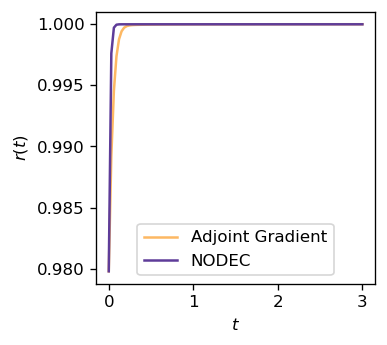

In [294]:
fig = comparison_plot(nn_r, adj_r, np.linspace(0, total_time, adj_r.shape[0]), '$r(t)$')
fig.savefig(result_folder + 'sync_param.pdf')

In [295]:
nn_r[-1], adj_r[-1], nn_e[-1], adj_e[-1]

(0.99998575, 0.9999918, 9543341.0, 10014154.0)

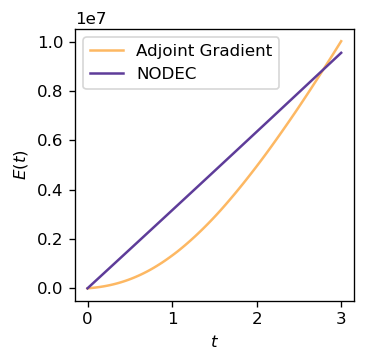

In [296]:
fig = comparison_plot(nn_e, adj_e, np.linspace(0, total_time, adj_e.shape[0]), '$E(t)$', legend_loc='upper left')
fig.savefig(result_folder + 'energy.pdf')

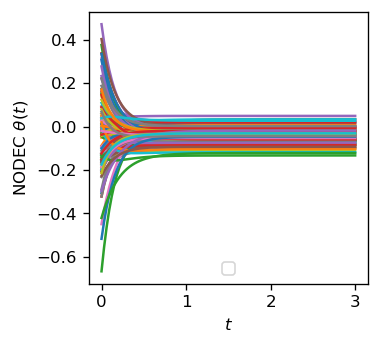

In [19]:
state_plot(nn_states, np.linspace(0, total_time, nn_states.shape[0]), "NODEC $\\theta (t)$")
fig.savefig(result_folder + 'nodec_states.pdf')

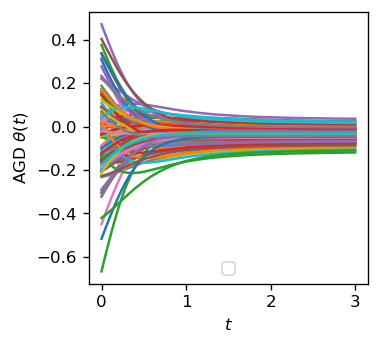

In [20]:
state_plot(adj_states, np.linspace(0, total_time, adj_states.shape[0]), "AGD $\\theta (t)$")
fig.savefig(result_folder + 'adj_states.pdf')

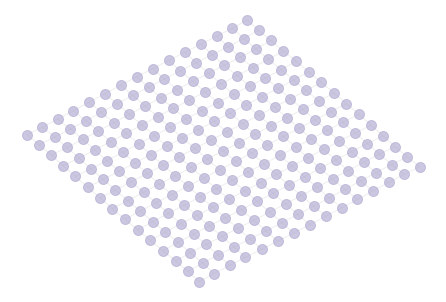

In [15]:
G = nx.from_numpy_matrix(adjacency_matrix.cpu().detach().numpy())
fig = nx.draw(G, nx.kamada_kawai_layout(G), node_size=100, node_color='#b2abd2aa', edge_color='#00000011')
plt.savefig(result_folder + 'graph.pdf')

In [298]:
import pandas as pd
data = pd.read_csv("runtime_comparison.csv")

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using d

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using d

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using d

INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using default.
INFO:matplotlib.texmanager:No LaTeX-compatible font found for the serif font family in rcParams. Using d

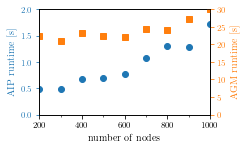

In [341]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib import rcParams

# customized settings
params = {  # 'backend': 'ps',
    'font.family': 'serif',
    'font.serif': 'Latin Modern Roman',
    'font.size': 10,
    'axes.labelsize': 'medium',
    'axes.titlesize': 'medium',
    'legend.fontsize': 'medium',
    'xtick.labelsize': 'small',
    'ytick.labelsize': 'small',
    'savefig.dpi': 150,
    'text.usetex': True}
    # tell matplotlib about your params

rcParams.update(params)
# set nice figure sizes
fig_width_pt = 255 # Get this from LaTeX using \showthe\columnwidth
golden_mean = (np.sqrt(5.) - 1.) / 2.  # Aesthetic ratio
ratio = golden_mean
inches_per_pt = 1. / 72.27  # Convert pt to inches
fig_width = fig_width_pt * inches_per_pt  # width in inches
fig_height = fig_width*ratio  # height in inches
fig_size = [fig_width, fig_height]
rcParams.update({'figure.figsize': fig_size})

fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(data["ER nodes"].to_numpy(),data["AIP mean runtime [s]"].to_numpy(),"o",color="tab:blue",label=r"AIP")
ax2.plot(data["ER nodes"].to_numpy(),data["AGM mean runtime [s]"].to_numpy(),"s",color="tab:orange",label=r"AGM")
plt.xlim(200,1000)
ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.set_xlabel(r"number of nodes")
ax.set_ylim(0,2)
ax2.set_ylim(0,30)
ax.set_ylabel(r"AIP runtime [s]",color="tab:blue")
ax2.set_ylabel(r"AGM runtime [s]",color="tab:orange")
ax.tick_params(axis='y', colors="tab:blue")
ax2.tick_params(axis='y', colors="tab:orange")
plt.tight_layout()
plt.rcParams['savefig.facecolor']='white'
plt.savefig('runtime.png', dpi = 480)
plt.show()

In [343]:
data["AGM mean runtime [s]"].to_numpy()/data["AIP mean runtime [s]"].to_numpy()

array([61.63736758, 46.65341505, 43.55656665, 34.20904301, 32.51217967,
       28.66048596, 22.75386697, 18.3482332 , 21.24295002, 17.46754068])